In [350]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
from tqdm import tqdm

In [351]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

## Exploring dataset

In [352]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [353]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [354]:
df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [355]:
# segregating features
# Check unique values for categorical data
categorical_col = list(set(df.columns) - set(df._get_numeric_data().columns))
for c in categorical_col:
    print(f'col {c}: ', df[c].unique())
one_hot_features = ['poutcome', 'job', 'marital', 'contact']
binary_features = ['loan', 'default', 'housing', 'y']
ordinal_features = {
    'day_of_week': {
        'mon': 1, 
        'tue': 2,
        'wed': 3,
        'thu': 4, 
        'fri': 5
    },
    'month': {
        'jan': 1,
        'feb': 2,
        'mar': 3,
        'apr': 4,
        'may': 5,
        'jun': 6, 
        'jul': 7,
        'aug': 8,
        'sep': 9,
        'oct': 10,
        'nov': 11, 
        'dec': 12
    },
    'education': {
        'illiterate': 0,
        'basic.4y': 1,
        'basic.6y': 2,
        'basic.9y': 3,
        'high.school': 4,
        'professional.course': 5,
        'university.degree': 6,
    }
}

col loan:  ['no' 'yes' 'unknown']
col education:  ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
col default:  ['no' 'unknown' 'yes']
col poutcome:  ['nonexistent' 'failure' 'success']
col job:  ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
col contact:  ['telephone' 'cellular']
col housing:  ['no' 'yes' 'unknown']
col marital:  ['married' 'single' 'divorced' 'unknown']
col day_of_week:  ['mon' 'tue' 'wed' 'thu' 'fri']
col month:  ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
col y:  ['no' 'yes']


In [356]:
feature_cols = set(df.columns) - set(['y'])
feature_cols

{'age',
 'campaign',
 'cons.conf.idx',
 'cons.price.idx',
 'contact',
 'day_of_week',
 'default',
 'duration',
 'education',
 'emp.var.rate',
 'euribor3m',
 'housing',
 'job',
 'loan',
 'marital',
 'month',
 'nr.employed',
 'pdays',
 'poutcome',
 'previous'}

In [357]:
# handle unknown, based on existing feature probabilities
for feature in feature_cols:
    vals = list(df[feature].unique())
    if 'unknown' not in vals:
        continue
    vals.remove('unknown')
    feature_vc = df[feature].value_counts()[vals]
    total_known = feature_vc.sum()
    prob = [(feature_vc[attr_val] / total_known) for attr_val in vals]
    rows_unknown = df[feature] == 'unknown'
    len_rows_unknown = rows_unknown.sum()
    df.loc[rows_unknown, feature] = np.random.choice(vals, len_rows_unknown, prob)

In [358]:
# handle binary features
for feature in binary_features:
    df[feature].replace({'yes': 1, 'no': 0}, inplace=True)

In [359]:
# one hot features
for feature in one_hot_features:
    one_hot = pd.get_dummies(df[feature])
    one_hot.set_axis([f'{feature}-{name}' for name in one_hot.columns], axis=1, inplace=True)
    df.drop(feature, axis=1, inplace=True)
    df = df.join(one_hot)

In [360]:
# ordinal features
for feature in ordinal_features:
    df[feature].replace(ordinal_features[feature], inplace=True)

## Splitting into training and testing

In [361]:
def split(train_ratio, df, shuffle=True):
    if shuffle:
        df = df.sample(frac=1)
    train_samples = int(train_ratio * len(df))
    return df.iloc[:train_samples].copy().reset_index(drop=True), df.iloc[train_samples:].copy().reset_index(drop=True)

In [362]:
df_train, df_test = split(0.7, df)

In [363]:
feature_cols = list(set(df.columns) - set(['y']))
X_train = df_train[feature_cols]
Y_train = df_train.y
X_test = df_test[feature_cols]
Y_test = df_test.y

## 2.1

In [364]:
# returns total samples weighted impurity of terminal nodes
def impurity_leaf_nodes(clf: DecisionTreeClassifier):
    n = clf.tree_.node_count
    is_leaf = [(clf.tree_.children_left[i] == clf.tree_.children_right[i]) for i in range(n)]
    total_impurity = 0
    num_samples = 0
    for i in range(n):
        if is_leaf[i]:
            total_impurity += (clf.tree_.n_node_samples[i] * clf.tree_.impurity[i])
            num_samples += clf.tree_.n_node_samples[i]
    return total_impurity / num_samples

In [365]:
ccp_alphas = np.linspace(0, 0.035, 25)
leaf_impurities = []
test_acc = []
train_acc = []
for ccp_alpha in tqdm(ccp_alphas):
    clf = DecisionTreeClassifier(ccp_alpha=ccp_alpha)
    clf = clf.fit(X_train, Y_train)
    leaf_impurities.append(impurity_leaf_nodes(clf))
    test_acc.append(metrics.accuracy_score(Y_test, clf.predict(X_test)))
    train_acc.append(metrics.accuracy_score(Y_train, clf.predict(X_train)))

100%|██████████| 25/25 [00:04<00:00,  5.32it/s]


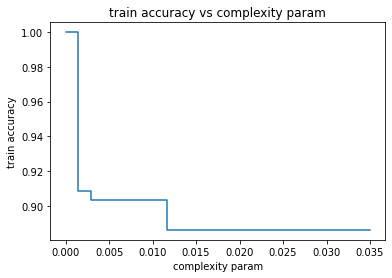

In [366]:
plt.plot(ccp_alphas, train_acc, drawstyle='steps-post')
plt.xlabel('complexity param')
plt.ylabel('train accuracy')
plt.title('train accuracy vs complexity param')
plt.show()

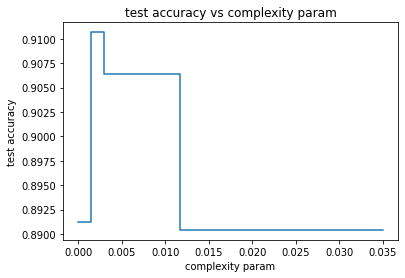

In [367]:
plt.plot(ccp_alphas, test_acc, drawstyle='steps-post')
plt.xlabel('complexity param')
plt.ylabel('test accuracy')
plt.title('test accuracy vs complexity param')
plt.show()

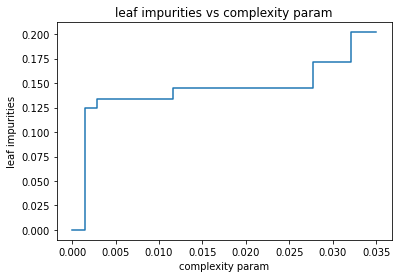

In [368]:
plt.plot(ccp_alphas, leaf_impurities, drawstyle='steps-post')
plt.xlabel('complexity param')
plt.ylabel('leaf impurities')
plt.title('leaf impurities vs complexity param')
plt.show()

## 2.2

In [369]:
pd.DataFrame({
    'Complexity params': ccp_alphas,
    'Train accuracy': train_acc,
    'Testing accuracy': test_acc
})

,Complexity params,Train accuracy,Testing accuracy
0,0.000000,1.000000,0.891236
1,0.001458,0.908605,0.910658
2,0.002917,0.903090,0.906369
3,0.004375,0.903090,0.906369
4,0.005833,0.903090,0.906369
5,0.007292,0.903090,0.906369
6,0.008750,0.903090,0.906369
7,0.010208,0.903090,0.906369
8,0.011667,0.886025,0.890426
9,0.013125,0.886025,0.890426


## 2.3

[]

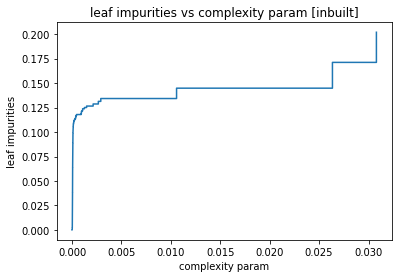

In [370]:
clf = DecisionTreeClassifier()
path = clf.cost_complexity_pruning_path(X_train, Y_train)
plt.plot(path.ccp_alphas, path.impurities, drawstyle='steps-post')
plt.xlabel('complexity param')
plt.ylabel('leaf impurities')
plt.title('leaf impurities vs complexity param [inbuilt]')
plt.plot()